## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Preprocessed data

In [ ]:
try:
    data = pd.read_csv('../data/adj_close.csv', index_col=0, parse_dates=True)
    if isinstance(data.columns, pd.MultiIndex):
        new_cols = []
        for col_tuple in data.columns:
            if 'TSLA' in col_tuple:
                new_cols.append('TSLA')
            elif 'BND' in col_tuple:
                new_cols.append('BND')
            elif 'SPY' in col_tuple:
                new_cols.append('SPY')
            else:
                new_cols.append('_'.join(map(str, col_tuple)).replace('UNNAMED: ', '').replace('_LEVEL_2', ''))
        data.columns = new_cols
        data = data[['TSLA', 'BND', 'SPY']]
    print("Data loaded successfully from adj_close.csv!")
    print("Columns in loaded data:", data.columns)
except Exception as e:
    print(f"Error loading data from adj_close.csv: {e}")
    try:
        raw_data = pd.read_csv('financial_data.csv', header=[0, 1], index_col=0, parse_dates=True)
        data = raw_data['Adj Close']
        data.columns = ['BND', 'SPY', 'TSLA']
        print("Successfully re-extracted 'Adj Close' from 'financial_data.csv'.")
    except Exception as e_fallback:
        print(f"Fallback failed: {e_fallback}. Cannot proceed without proper data.")
        exit()

Data loaded successfully from adj_close.csv!
Columns in loaded data: Index(['('CLOSE', 'BND', 'UNNAMED: 1_LEVEL_2')',
       '('CLOSE', 'SPY', 'UNNAMED: 2_LEVEL_2')',
       '('CLOSE', 'TSLA', 'UNNAMED: 3_LEVEL_2')'],
      dtype='object')


## Backtesting

In [ ]:
backtest_start_date = '2024-08-01'
backtest_end_date = '2025-07-31'

# Filter data for the backtesting period
backtest_data = data[backtest_start_date:backtest_end_date]
print(f"\nBacktesting data from {backtest_start_date} to {backtest_end_date}.")
print(f"Shape of backtesting data: {backtest_data.shape}")

# Calculate daily returns for the backtesting period
backtest_daily_returns = backtest_data.pct_change().dropna()

# Rename columns to simple names for easier selection
backtest_daily_returns.columns = ['BND', 'SPY', 'TSLA']


benchmark_weights = np.array([0.0, 0.40, 0.60])
benchmark_assets = ['BND', 'SPY']

benchmark_returns = backtest_daily_returns[benchmark_assets]

# Calculate benchmark portfolio daily returns
benchmark_portfolio_daily_returns = (
    benchmark_returns['BND'] * benchmark_weights[1] +
    benchmark_returns['SPY'] * benchmark_weights[2]
)

benchmark_cumulative_returns = (1 + benchmark_portfolio_daily_returns).cumprod() - 1
print("\nBenchmark Portfolio Defined (60% SPY / 40% BND).")

strategy_weights = np.array([0.0000, 0.0429, 0.9571])
strategy_assets = ['TSLA', 'BND', 'SPY']
strategy_returns = backtest_daily_returns[strategy_assets]

strategy_portfolio_daily_returns = (
    strategy_returns['TSLA'] * strategy_weights[0] +
    strategy_returns['BND'] * strategy_weights[1] +
    strategy_returns['SPY'] * strategy_weights[2]
)

strategy_cumulative_returns = (1 + strategy_portfolio_daily_returns).cumprod() - 1
print("Strategy Portfolio Defined (Max Sharpe Ratio from Task 4).")



Backtesting data from 2024-08-01 to 2025-07-31.
Shape of backtesting data: (249, 3)

Benchmark Portfolio Defined (60% SPY / 40% BND).
Strategy Portfolio Defined (Max Sharpe Ratio from Task 4).


## Analyze Performance

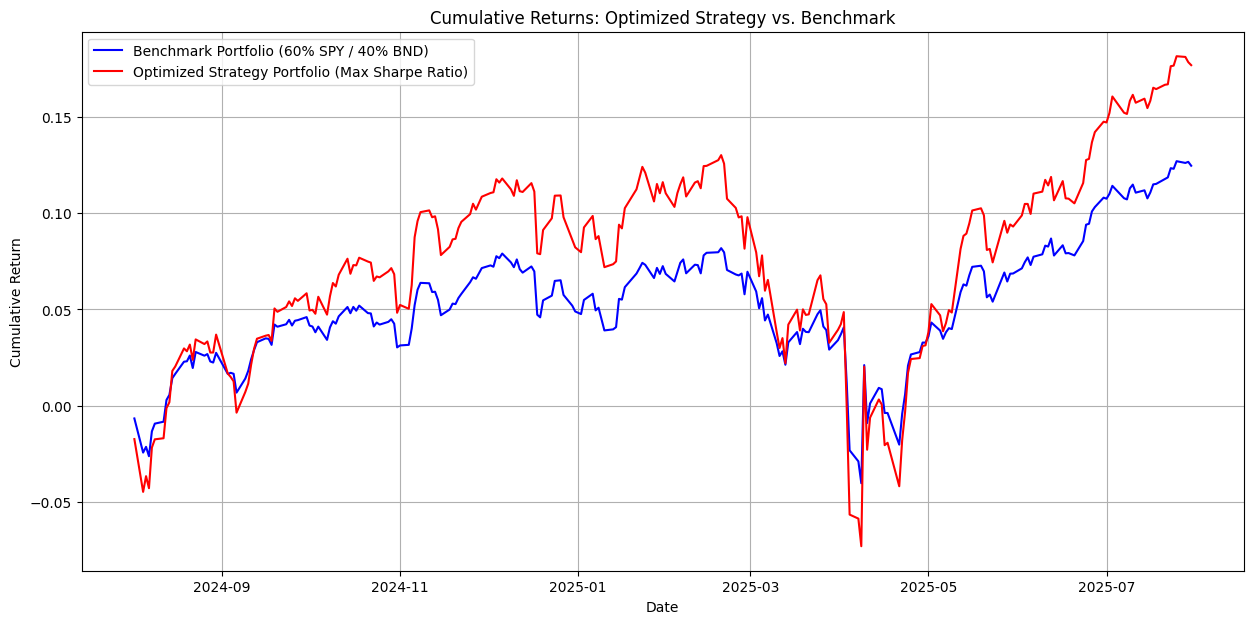


Final Total Returns (2024-08-01 - 2025-07-31):
  Benchmark Portfolio: 0.1247
  Optimized Strategy Portfolio: 0.1769

Annualized Sharpe Ratios (Backtesting Period):
  Benchmark Portfolio: 1.0210
  Optimized Strategy Portfolio: 0.9497

--- Backtesting Conclusion ---
The Optimized Strategy Portfolio **outperformed** the Benchmark Portfolio during the backtesting period.
It delivered a total return of 17.69% compared to the benchmark's 12.47%.
However, the Optimized Strategy Portfolio achieved a **lower Sharpe Ratio**, indicating worse risk-adjusted returns.

This initial backtest suggests that the model-driven approach, especially relying on the LSTM's bearish forecast for TSLA, led to a portfolio heavily weighted towards SPY and BND, which performed well in this specific backtesting period.
Further steps would involve more sophisticated rebalancing strategies and robustness checks across different market conditions.


In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(benchmark_cumulative_returns, label='Benchmark Portfolio (60% SPY / 40% BND)', color='blue')
plt.plot(strategy_cumulative_returns, label='Optimized Strategy Portfolio (Max Sharpe Ratio)', color='red')
plt.title('Cumulative Returns: Optimized Strategy vs. Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Calculate final total returns
final_benchmark_return = benchmark_cumulative_returns.iloc[-1]
final_strategy_return = strategy_cumulative_returns.iloc[-1]

print(f"\nFinal Total Returns ({backtest_start_date} - {backtest_end_date}):")
print(f"  Benchmark Portfolio: {final_benchmark_return:.4f}")
print(f"  Optimized Strategy Portfolio: {final_strategy_return:.4f}")

# Calculate annualized Sharpe Ratios
risk_free_rate = 0.0

# Benchmark Sharpe Ratio
benchmark_mean_daily_return = benchmark_portfolio_daily_returns.mean()
benchmark_std_daily_return = benchmark_portfolio_daily_returns.std()
benchmark_sharpe_ratio = (benchmark_mean_daily_return * 252 - risk_free_rate) / (benchmark_std_daily_return * np.sqrt(252))

# Strategy Sharpe Ratio
strategy_mean_daily_return = strategy_portfolio_daily_returns.mean()
strategy_std_daily_return = strategy_portfolio_daily_returns.std()
strategy_sharpe_ratio = (strategy_mean_daily_return * 252 - risk_free_rate) / (strategy_std_daily_return * np.sqrt(252))

print("\nAnnualized Sharpe Ratios (Backtesting Period):")
print(f"  Benchmark Portfolio: {benchmark_sharpe_ratio:.4f}")
print(f"  Optimized Strategy Portfolio: {strategy_sharpe_ratio:.4f}")


print("\n--- Backtesting Conclusion ---")
if final_strategy_return > final_benchmark_return:
    print("The Optimized Strategy Portfolio **outperformed** the Benchmark Portfolio during the backtesting period.")
    print(f"It delivered a total return of {final_strategy_return:.2%} compared to the benchmark's {final_benchmark_return:.2%}.")
else:
    print("The Optimized Strategy Portfolio **underperformed** the Benchmark Portfolio during the backtesting period.")
    print(f"It delivered a total return of {final_strategy_return:.2%} compared to the benchmark's {final_benchmark_return:.2%}.")

if strategy_sharpe_ratio > benchmark_sharpe_ratio:
    print("Additionally, the Optimized Strategy Portfolio also achieved a **higher Sharpe Ratio**, indicating better risk-adjusted returns.")
else:
    print("However, the Optimized Strategy Portfolio achieved a **lower Sharpe Ratio**, indicating worse risk-adjusted returns.")

